In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import collections
import random
import datetime
import scipy as sci
from scipy.integrate import odeint
from scipy.integrate import solve_ivp


In [2]:
N=40 #number of agents
v0=2

lambda1_v = -8.414e-03 
lambda2_v = 1.833e-01 
lambda3_v = -4.845e-03 
lambda4_v = -2.210e-01
power1_v = -9.465e-03 
power2_v = -3.977e-02 
power3_v = 3.053e-01
int_range = 1.000e+00


L= 40**(0.5)/4

def total_infer_x(s,i):
    n_array = np.array(n)
    self_index=np.repeat(i,n-1)
    
    others_index=list(range(n))
    others_index.remove(i)
    
    x1_array = np.take(s, self_index)
    y1_array = np.take(s, self_index + n_array)
    x2_array = np.take(s, others_index)
    y2_array = np.take(s, others_index + n_array)
    
    
    temp_x1 = x1_array - (2*L)*np.trunc(x1_array/(2*L))
    temp_y1 = y1_array - (2*L)*np.trunc(y1_array/(2*L))
    temp_x2 = x2_array - (2*L)*np.trunc(x2_array/(2*L))
    temp_y2 = y2_array - (2*L)*np.trunc(y2_array/(2*L))
    
    x1=temp_x1 - 2*L*np.trunc(temp_x1/L)  #self
    y1=temp_y1 - 2*L*np.trunc(temp_y1/L)#self
    x2=temp_x2 - 2*L*np.trunc(temp_x2/L)
    y2=temp_y2 - 2*L*np.trunc(temp_y2/L)
    

    dist=((x1-x2)**2 + (y1-y2)**2)**(1/2)
    

    vi_x=np.take(s, 2*n_array + self_index) #self
    vi_y=np.take(s, 3*n_array + self_index) #self
    vj_x=np.take(s, 2*n_array + others_index)
    vj_y=np.take(s, 3*n_array + others_index)
    vel_rel=((vi_x-vj_x)**2 + (vi_y-vj_y)**2)**(1/2)
    
    local_dist_func = np.heaviside(int_range - dist,1)
    
    F_int_x=(vi_x-vj_x)/vel_rel*(lambda1_v*(dist**power1_v)+lambda2_v*(dist**power2_v)+lambda3_v*(dist**power3_v)+lambda4_v)*local_dist_func
    
    total_interaction_x=sum(F_int_x)
    
    v_i_x=s[2*n+i]
    v_i_y=s[3*n+i]
    v_i_mag = (v_i_x**2+v_i_y**2)**(1/2)
    self_propel_x = 1*(v_i_x/v_i_mag)*(v0-v_i_mag)

    return self_propel_x+total_interaction_x


def total_infer_y(s,i):
    n_array = np.array(n)
    self_index=np.repeat(i,n-1)
    
    others_index=list(range(n))
    others_index.remove(i)
    
    x1_array = np.take(s, self_index)
    y1_array = np.take(s, self_index + n_array)
    x2_array = np.take(s, others_index)
    y2_array = np.take(s, others_index + n_array)
    
    
    temp_x1 = x1_array - (2*L)*np.trunc(x1_array/(2*L))
    temp_y1 = y1_array - (2*L)*np.trunc(y1_array/(2*L))
    temp_x2 = x2_array - (2*L)*np.trunc(x2_array/(2*L))
    temp_y2 = y2_array - (2*L)*np.trunc(y2_array/(2*L))
    
    x1=temp_x1 - 2*L*np.trunc(temp_x1/L)  #self
    y1=temp_y1 - 2*L*np.trunc(temp_y1/L)#self
    x2=temp_x2 - 2*L*np.trunc(temp_x2/L)
    y2=temp_y2 - 2*L*np.trunc(temp_y2/L)
    
    dist=((x1-x2)**2 + (y1-y2)**2)**(1/2)
    

    vi_x=np.take(s, 2*n_array + self_index) #self
    vi_y=np.take(s, 3*n_array + self_index) #self
    vj_x=np.take(s, 2*n_array + others_index)
    vj_y=np.take(s, 3*n_array + others_index)
    vel_rel=((vi_x-vj_x)**2 + (vi_y-vj_y)**2)**(1/2)
    
    local_dist_func = np.heaviside(int_range - dist,1)
    
    F_int_y=(vi_y-vj_y)/vel_rel*(lambda1_v*(dist**power1_v)+lambda2_v*(dist**power2_v)+lambda3_v*(dist**power3_v)+lambda4_v)*local_dist_func

    
    total_interaction_y=sum(F_int_y)
    
    v_i_x=s[2*n+i]
    v_i_y=s[3*n+i]
    v_i_mag = (v_i_x**2+v_i_y**2)**(1/2)
    self_propel_y = 1*(v_i_y/v_i_mag)*(v0-v_i_mag)

    return self_propel_y+total_interaction_y


def F_infer_ivp(t,s):
    return np.concatenate((s[2*n:3*n],s[3*n:4*n],\
                           [total_infer_x(s,i) for i in range(n)]+np.random.normal(0,1,size=n),\
                           [total_infer_y(s,i) for i in range(n)]+np.random.normal(0,1,size=n)))



In [3]:
##########Inital condition ##########

position_list_x=[]
position_list_y=[]
velocity_list_x=[]
velocity_list_y=[]
random.seed(101)
# random.seed()
for i in range(40):
    position_list_x.append(random.uniform(-L, L))
    position_list_y.append(random.uniform(-L, L))
    velocity_list_x.append(random.uniform(-2,2))
    velocity_list_y.append(random.uniform(-2,2))

nodes_np = np.array([position_list_x, position_list_y, velocity_list_x, velocity_list_y], dtype=np.float32)

s0=nodes_np.reshape(-1)
n=nodes_np.shape[1]

In [4]:
dt=0.1
T=40
t=np.arange(0,T+dt,dt)
solution=solve_ivp(F_infer_ivp,[0,T],s0, method='RK45', max_step= 0.01, t_eval=t)
print(solution)


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 106430
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12

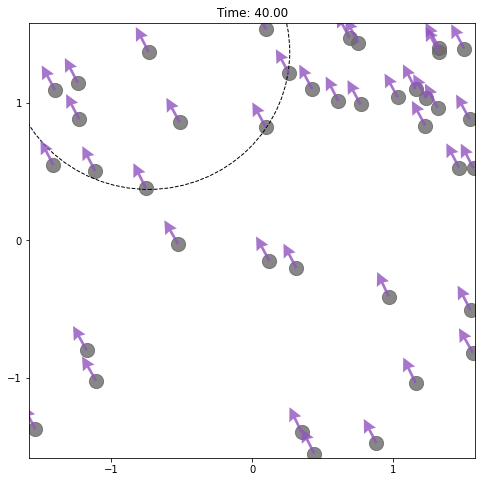

In [5]:
import matplotlib.animation as animation

solution_plot=np.transpose(solution.y)

t_plot=np.arange(0,T+dt ,dt)
temp = solution_plot[:,0:2*n]- 2*L*np.trunc(solution_plot[:,0:2*n]/(2*L))
h = temp- 2*L*np.trunc(temp/L)
velocity=solution_plot[:,2*n:4*n]

fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
window=L
speed = 1

############################### order parameter #####################
velocity_x = velocity[:,0:n]
velocity_y = velocity[:,n:]
center_x = np.mean(h[:,0:n],axis=1,keepdims=True)
center_y = np.mean(h[:,n:],axis=1,keepdims=True)
r_x, r_y = h[:,0:n]-center_x, h[:,n:]-center_y

r_mag = np.sqrt(np.square(r_x)+np.square(r_y))
vel_mag=np.sqrt(np.square(velocity_x)+np.square(velocity_y)) #N X V
vel_mag_sum=np.sum(vel_mag, axis=1)

vel_x_sum = np.sum(velocity_x, axis=1)
vel_y_sum = np.sum(velocity_y, axis=1)

vel_vec_mag = np.sqrt(np.square(vel_x_sum)+np.square(vel_y_sum)) # abs(sum of velocity vector)

order_para = vel_vec_mag/vel_mag_sum

ang_mom = r_x*velocity_y - r_y * velocity_x

denom = np.sum(r_mag*vel_mag, axis=1)
ang_mom_sum = np.abs(np.sum(r_x*velocity_y - r_y * velocity_x, axis=1))
ang_mom_abs = np.sum(np.abs(r_x*velocity_y - r_y * velocity_x), axis=1)

order_para_rot = ang_mom_sum/denom
order_para_rot_abs = ang_mom_abs/denom

##########################################################################
init_color = np.array([0.,0.,0.])
cw_color =  np.array([0.,100.,250.])
ccw_color =  np.array([240.,84.,0.])
flock_color = np.array([145.,84.,192.])
agent_color = np.array([105./255,105./255,105./255,0.8])

        
        
def animate(i):
#     f = i*int(dt/0.1)
    ax.clear()
    plt.scatter(h[i*speed,0:n],h[i*speed,n:], color=agent_color, s=200, zorder=0)
    
    rot_color = []
    for ii in range(len(ang_mom[i*speed,:])):
        if order_para[i*speed]>0.7:
            rot_color.append(np.append(flock_color*(order_para[i*speed]-0.7)/0.3/255, [0.8]))
        else:
            rot_color.append(np.append(init_color,[0.8]))
    
    origin=np.array([h[i*speed,0:n], h[i*speed,n:]])
    plt.quiver(*origin, velocity[i*speed,0:n], velocity[i*speed,n:], scale_units='xy', angles='xy', color=rot_color, \
               scale=10, width=0.006, headwidth=5,zorder=2)
    
    circle_0 = plt.Circle((h[i,0], h[i,n+0]), radius = int_range,fill=False, ls = '--')
    ax.add_artist(circle_0)

    
    ax.set_title('Time: {:.2f}'.format(t[i*speed]))
    ax.set_xticks(np.arange(-10, 10, 1))
    ax.set_yticks(np.arange(-10, 10, 1))
    ax.set_xlim(- window, window)
    ax.set_ylim(- window, window)



anim = animation.FuncAnimation(fig, animate, frames=len(t_plot))


from IPython.display import HTML

HTML(anim.to_html5_video())